# How to use $\texttt{LieDetect}$

Henrique Hennes https://github.com/HLovisiEnnes \
Raphaël Tinarrage https://raphaeltinarrage.github.io/

See the repo at https://github.com/HLovisiEnnes/LieDetect and the article at https://arxiv.org/abs/2309.03086

- **I. Representations of $\mathrm{SO}(2)$**
    - I.1. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$
    - I.2. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$
    - I.3. Dimension reduction
- **II. Representations of $T^2$**
    - II.1. Representation of $T^2$ in $\mathbb{R}^6$
    - II.2. Representation of $T^2$ in $\mathbb{R}^8$
- **III. Representations of $T^3$**
    - III.1. Representation of $T^3$ in $\mathbb{R}^8$
    - III.2. Representation of $T^3$ in $\mathbb{R}^{10}$
- **IV. Representations of $\mathrm{SU(2)}$ and $\mathrm{SO}(3)$**
    - IV.1. Representation of $\mathrm{SO}(3)$ in $\mathbb{R}^5$
    - IV.2. Representation of $\mathrm{SU}(2)$ in $\mathbb{R}^7$
- **V. Additional experiments**
    - V.1. Comparison of two candidates: $\mathrm{SO}(3)$ and $T^3$ in $\mathbb{R}^6$
    - V.2. Non-transitive action: Möbius strip in $\mathbb{R}^4$

**Note:** Our algorithm may not always converge, therefore it may be necessary to run it multiple times to obtain satisfactory results. This is due to the possibility of getting stuck in local minimum, when using the *full_lie_pca* or *bottom_lie_pca* methods.

In [1]:
# Third-party imports.
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Local imports.
from algebra import are_representations_equivalent
from orbits import sample_orbit_from_group, sample_orbit_from_rep, sample_orbit_from_algebra, print_hausdorff_distance
from liepca import get_lie_pca_operator, print_covariance_eigenvalues, project_on_minimal_subspace
from optimization import find_closest_algebra

# I. Representations of $\mathrm{SO}(2)$

## I.1. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^4$

Our first example is a representation of $\mathrm{SO}(2)$ in dimension $4$.
We wish to recover the weights of the representation. In the next cell, we generate the point cloud. It is drawn uniformly on the orbit of a representation of $\mathrm{SO}(2)$, whose decomposition into irreps is also drawn randomly. Here, the representation is chosen almost-faithful, and composed of distinct irreps, so that the orbit spans the whole space $\mathbb{R}^4$. For visualization purpose, all figures are projections in dimension $3$.

Sampled 500 random points on the orbit of torus with rep ((-4, -3),).


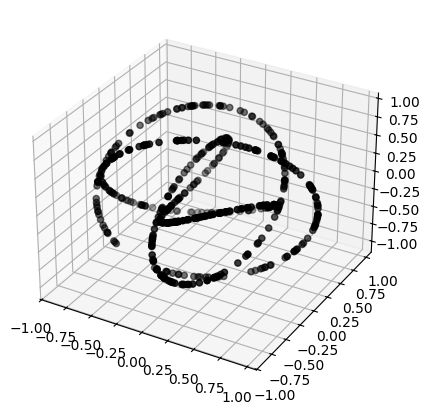

In [2]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 1  # dimension of the group (here, circle)
ambient_dim = 4  # ambient dimension
nb_points = 500  # number of sample points
frequency_max = 4  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=True,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black')
plt.show()

Next, we apply Lie-PCA. Two methods are available: *covariance*, that do not use pruning of the eigenvectors, and (local) *PCA*, that does. On both methods, we already see that the Lie-PCA operator has one significantly small eigenvalue. This is an indicator of the fact that the underlying orbit is generated by $\mathrm{SO}(2)$.

Lie PCA first eigenvalues: 6.1e-04  1.1e-01  1.2e-01  1.3e-01  Eigengap #1: 1.9e+02.


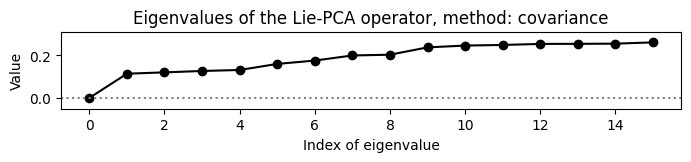

Lie PCA first eigenvalues: 6.0e-04  1.2e-01  1.2e-01  1.3e-01  Eigengap #1: 1.9e+02.


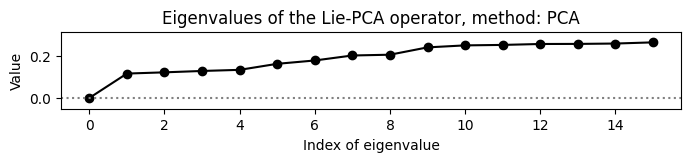

In [3]:
' Lie-PCA '

# Parameters.
nb_neighbors = 10  # number of neighbors for estimating tangent spaces
orbit_dim = 1  # dimension for estimating tangent spaces

for method in ["covariance", "PCA"]:
    # Compute Lie PCA operator.
    lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method,
                                   correction=False, verbose=True)

    # Plot its eigenvalues.
    vals = np.sort(np.linalg.eigvals(lie_pca).real)
    _, ax = plt.subplots(figsize=(8, 1))
    ax.plot(range(len(vals)), vals, c="black")
    ax.scatter(range(len(vals)), vals, c="black")
    ax.axhline(0, color="grey", linestyle="dotted")
    ax.set_ylim((0 - 0.05, max(vals) + 0.05))
    ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
    ax.set_xlabel("Index of eigenvalue")
    ax.set_ylabel("Value")
    plt.show()

We now find the pushforward Lie algebra of $\mathrm{SO}(2)$ the more likely to generate the orbit underlying the point cloud.
This is based on the Lie-PCA operator.
To this end, we implemented three methods:
- *full_lie_pca*: seeks a pushforward algebra that minimizes Lie PCA operator.
- *bottom_lie_pca*: seeks a pushforward algebra close to the bottom eigenvectors of the Lie PCA operator.
- *abelian*: computes the normal for of the bottom eigenvectors of the Lie PCA operator and finds the closest lattice. Only for Abelian groups.

We see that the three methods allow to recover exactly the frequencies, and give an accurate estimation of the underlying orbit.

----> Optimization problem via full_lie_pca method for torus  <----
Solve minimization problem... It 6/6. Duration 0:00:17. Remaining 0:00:00.
The optimal rep found is ((3, 4),) with cost 8.537e-04.
The representations ((-4, -3),) and ((3, 4),) are equivalent.
Non-symmetric Hausdorff distance: 1.827e-01.


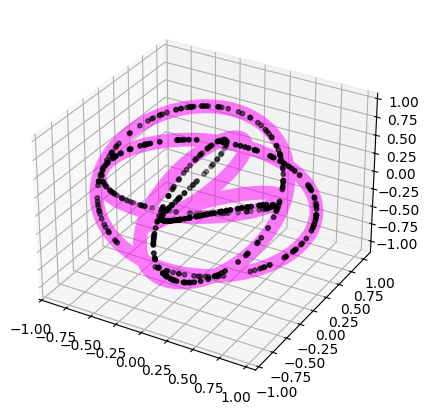

----> Optimization problem via bottom_lie_pca method for torus  <----
Solve minimization problem... It 6/6. Duration 0:00:01. Remaining 0:00:00.
The optimal rep found is ((3, 4),) with cost 6.280e-06.
The representations ((-4, -3),) and ((3, 4),) are equivalent.
Non-symmetric Hausdorff distance: 1.342e-02.


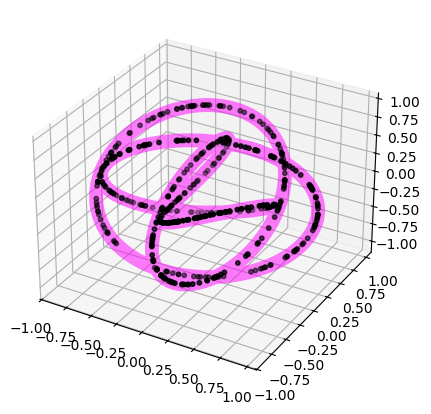

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((3, 4),) with cost 1.769e-03.
The representations ((-4, -3),) and ((3, 4),) are equivalent.
Non-symmetric Hausdorff distance: 1.355e-02.


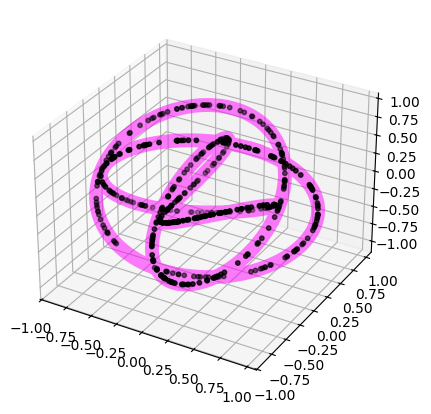

In [4]:
' Project on Lie subalgebras '

# Parameters.
frequency_max = 4  # maximal weight to search

for method in ["full_lie_pca", "bottom_lie_pca", "abelian"]:
    # Optimization.
    optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                        frequency_max=frequency_max, span_ambient_space=True,
                                                        method=method, verbose=True)

    # Sanity check: orbit-equivalence of reps.
    are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

    # Sanity check: Hausdorff distance.
    orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                      nb_points=1000, method="uniform", verbose=False, )
    print_hausdorff_distance(pts, orbit)

    # Plot orbit.
    pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
    pts_pca = pca.transform(pts)
    orbit_pca = pca.transform(orbit)
    _, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
    ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=10)
    ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c="magenta", lw=10, alpha=0.5)
    plt.show()

## I.2. Representation of $\mathrm{SO}(2)$ in $\mathbb{R}^6$

We reproduce the same experiment, $\mathrm{SO}(2)$ being now represented in dimension $6$.

Sampled 500 random points on the orbit of torus with rep ((1, 4, 3),).


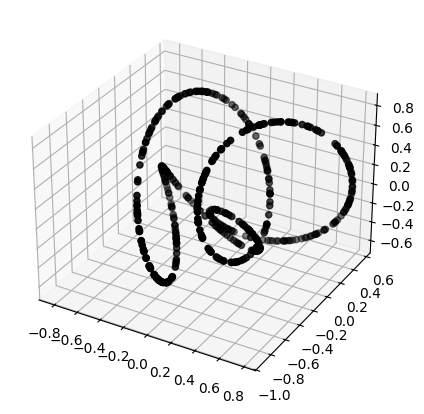

Lie PCA first eigenvalues: 3.3e-04  7.6e-02  8.1e-02  8.2e-02  Eigengap #1: 2.3e+02.


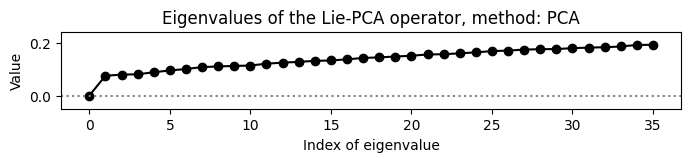

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 3, 4),) with cost 2.167e-03.
The representations ((1, 4, 3),) and ((1, 3, 4),) are equivalent.
Non-symmetric Hausdorff distance: 1.432e-02.


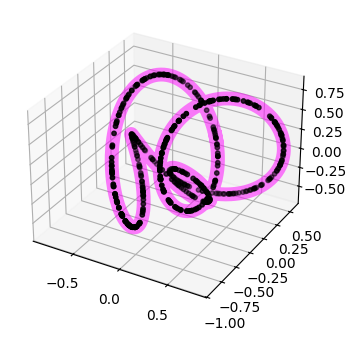

In [5]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 1  # dimension of the group (here, circle)
ambient_dim = 6  # ambient dimension
nb_points = 500  # number of sample points
frequency_max = 4  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=True,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black')
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 10  # number of neighbors for estimating tangent spaces
orbit_dim = 1  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=False,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 4  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0], nb_points=1000,
                                  method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(4, 4), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=10)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c="magenta", lw=10, alpha=0.5)
plt.show()

## I.3. Dimension reduction

The consistency of our method is based on the assumption that the underlying orbit lives in a minimal-dimensional subspace. If not, the isometry group $\mathrm{Isom}(\mathcal{O})$ is not equal to the symmetry group $\mathrm{Sym}(\mathcal{O})$, and our algorithm may return inconsistent Lie algebras.
This is the case for the point cloud below, where the representation has weights $(1,1,2)$.

Sampled 200 random points on the orbit of torus with rep ((1, 1, 2),).
Covariance eigenvalues: 3.5e-01  3.2e-01  1.9e-01  1.4e-01  3.1e-17  -1.8e-17 
Lie PCA first eigenvalues: -4.9e-17  -1.9e-17  -1.9e-17  -1.6e-17  Eigengap #1: 3.8e-01.


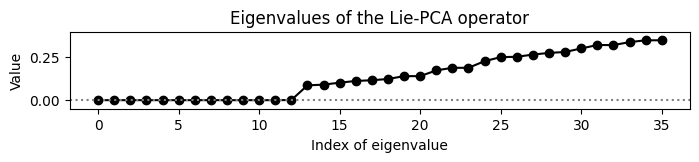

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2, 4),) with cost 2.197e-01.
The representations ((1, 1, 2),) and ((1, 2, 4),) are not equivalent.
Non-symmetric Hausdorff distance: 1.173e+00.


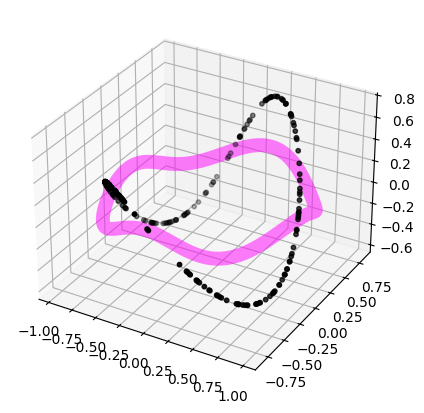

In [6]:
' Generate dataset '

# Generate an orbit that is not ambient-dimensional.
group = "torus"
group_dim = 1
groundtruth_rep = ((1, 1, 2),)
nb_points = 200
pts = sample_orbit_from_rep(group=group, rep_type=groundtruth_rep, nb_points=nb_points, method="random", verbose=True)

# Print eigenvalues of covariance matrix.
print_covariance_eigenvalues(pts=pts)

' Lie-PCA '

# Lie PCA operator sees a large symmetry group (actually made of matrices acting trivially).
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=10, orbit_dim=1, method="PCA", correction=False, verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title("Eigenvalues of the Lie-PCA operator")
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 4  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0], nb_points=1000,
                                  method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=10)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c="magenta", lw=10, alpha=0.5)
plt.show()

In order to remedy to this problem, we project the point cloud in a minimal-dimensional subspace.
Applying our algorithm again gives accurate results.

Covariance eigenvalues: 3.5e-01  3.2e-01  1.9e-01  1.4e-01 
Lie PCA first eigenvalues: 7.0e-04  8.6e-02  9.1e-02  1.0e-01  Eigengap #1: 1.2e+02.


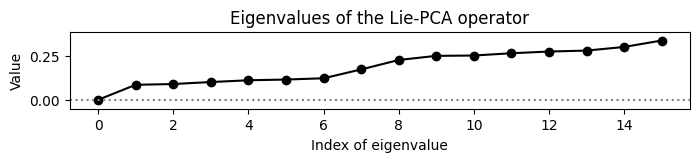

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2),) with cost 4.161e-03.
The representations ((1, 2),) and ((1, 2),) are equivalent.
Non-symmetric Hausdorff distance: 9.709e-03.


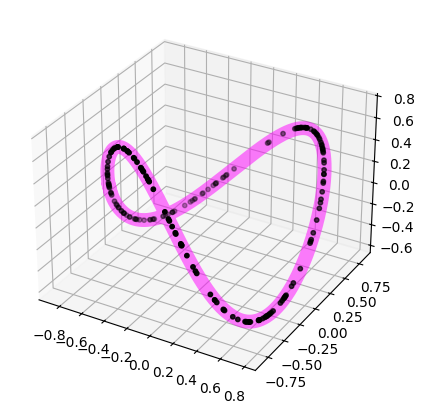

In [7]:
' Dimension reduction '

# Project in minimal-dimensional subspace
pts = project_on_minimal_subspace(pts=pts, threshold_eigenvalue=1e-15)
groundtruth_rep = ((1, 2),)
print_covariance_eigenvalues(pts=pts)

# Now, the kernel of the Lie PCA operator is smaller.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=10, orbit_dim=1, method="PCA", correction=False, verbose=True, )

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title("Eigenvalues of the Lie-PCA operator")
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 4  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0], nb_points=1000,
                                  method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=10)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c="magenta", lw=10, alpha=0.5)
plt.show()

# II. Representations of $T^2$

## II.1. Representation of $T^2$ in $\mathbb{R}^6$

Sampled 1000 random points on the orbit of torus with rep ((1, -1, 0), (0, -2, 1)).


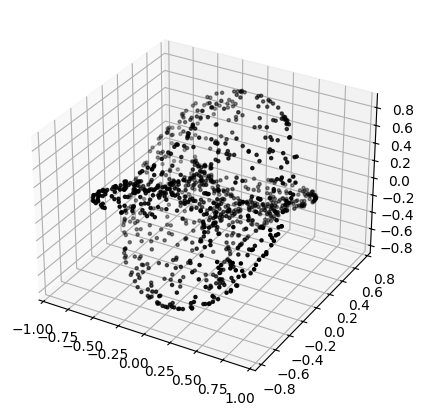

Lie PCA first eigenvalues: 1.5e-03  2.0e-03  5.2e-02  5.6e-02  Eigengap #2: 2.6e+01.


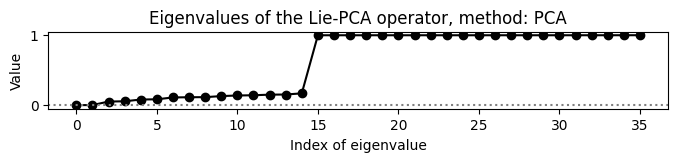

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((-1, 0, 1), (0, 1, 2)) with cost 1.854e-02.
The representations ((1, -1, 0), (0, -2, 1)) and ((-1, 0, 1), (0, 1, 2)) are equivalent.
Non-symmetric Hausdorff distance: 4.017e-02.


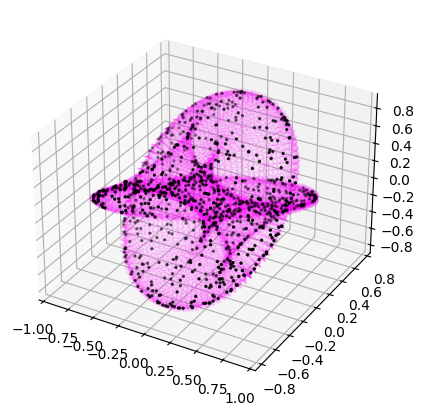

In [8]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 2  # dimension of the group
ambient_dim = 6  # ambient dimension
nb_points = 1000  # number of sample points
frequency_max = 2  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=False,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 20  # number of neighbors for estimating tangent spaces
orbit_dim = 2  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 2  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=100 ** 2, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

## II.2. Representation of $T^2$ in $\mathbb{R}^8$

Sampled 3000 random points on the orbit of torus with rep ((-2, 1, 2, -1), (2, -2, -1, 0)).


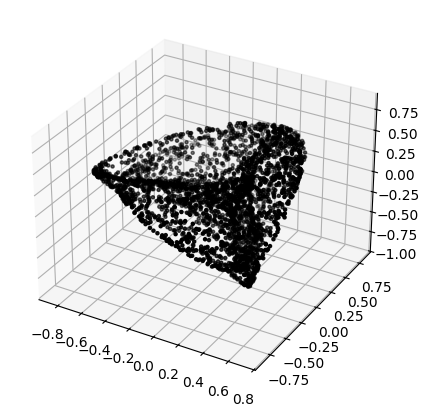

Lie PCA first eigenvalues: 2.0e-04  2.3e-04  6.3e-02  6.4e-02  Eigengap #3: 1.0e+00.


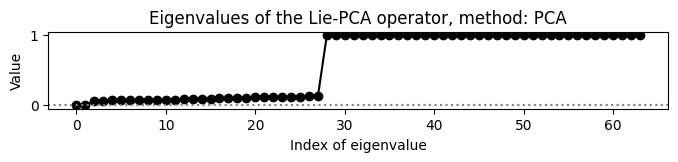

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((-2, -2, -1, 0), (-1, -2, -2, -1)) with cost 1.737e-02.
The representations ((-2, 1, 2, -1), (2, -2, -1, 0)) and ((-2, -2, -1, 0), (-1, -2, -2, -1)) are equivalent.
Non-symmetric Hausdorff distance: 5.096e-02.


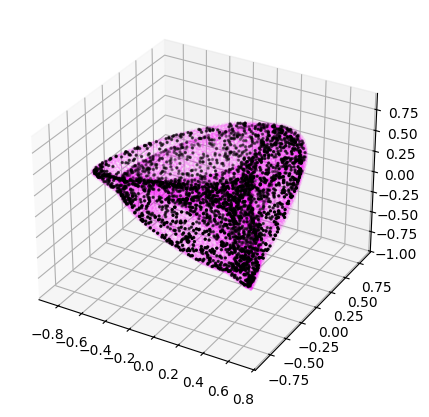

In [9]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 2  # dimension of the group
ambient_dim = 8  # ambient dimension
nb_points = 3000  # number of sample points
frequency_max = 2  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=False,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 2  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=100 ** 2, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

# III. Representations of $T^3$

## III.1. Representation of $T^3$ in $\mathbb{R}^8$

Sampled 3000 random points on the orbit of torus with rep ((-1, 1, -2, 0), (2, -2, -1, 0), (-2, 1, 0, 2)).


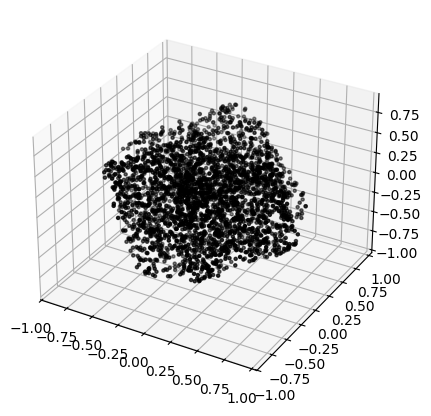

Lie PCA first eigenvalues: 2.7e-03  3.6e-03  4.2e-03  6.1e-02  Eigengap #3: 1.4e+01.


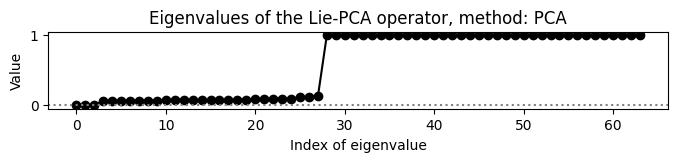

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((0, 0, -1, 0), (-1, 0, 0, -2), (0, -1, 0, -2)) with cost 2.513e-02.
The representations ((-1, 1, -2, 0), (2, -2, -1, 0), (-2, 1, 0, 2)) and ((0, 0, -1, 0), (-1, 0, 0, -2), (0, -1, 0, -2)) are equivalent.
Non-symmetric Hausdorff distance: 1.980e-01.


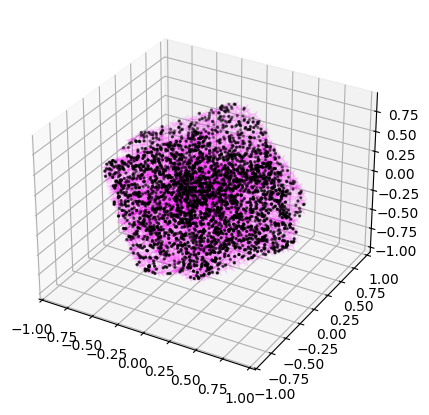

In [10]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 3  # dimension of the group
ambient_dim = 8  # ambient dimension
nb_points = 3000  # number of sample points
frequency_max = 2  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=False,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 2  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=100 ** 2, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

## III.2. Representation of $T^3$ in $\mathbb{R}^{10}$

Sampled 3000 random points on the orbit of torus with rep ((0, 0, 0, 1, 1), (1, 1, 0, 0, 0), (1, 0, -1, 0, 1)).


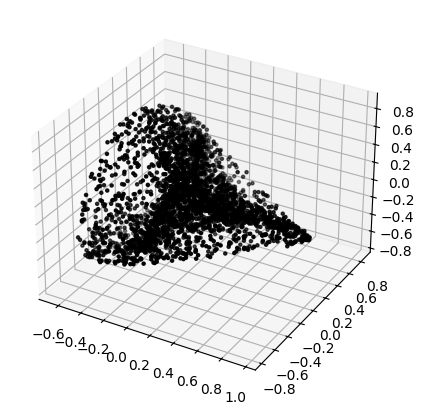

Lie PCA first eigenvalues: 1.4e-03  1.5e-03  1.6e-03  4.8e-02  Eigengap #3: 3.0e+01.


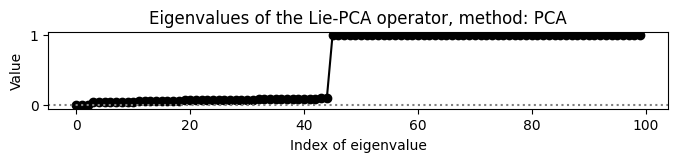

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((-1, 0, 0, 1, 0), (0, 1, 0, 0, -1), (-1, 1, -1, 0, 0)) with cost 1.330e-02.
The representations ((0, 0, 0, 1, 1), (1, 1, 0, 0, 0), (1, 0, -1, 0, 1)) and ((-1, 0, 0, 1, 0), (0, 1, 0, 0, -1), (-1, 1, -1, 0, 0)) are equivalent.
Non-symmetric Hausdorff distance: 1.446e-01.


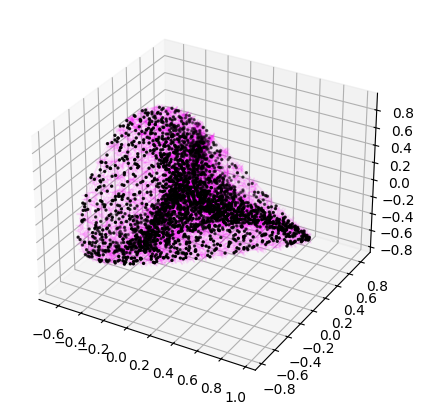

In [11]:
' Generate dataset '

# Parameters.
group = "torus"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 3  # dimension of the group
ambient_dim = 10  # ambient dimension
nb_points = 3000  # number of sample points
groundtruth_rep = ((0, 0, 0, 1, 1), (1, 1, 0, 0, 0), (1, 0, -1, 0, 1))

# Generate dataset and plot.
pts = sample_orbit_from_rep(group=group, rep_type=groundtruth_rep, nb_points=nb_points, method="random", verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
frequency_max = 1  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=True, method=method,
                                                    verbose=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=100 ** 2, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

# IV. Representations of $\mathrm{SU}(2)$ and $\mathrm{SO}(3)$

## IV.1. Representation of $\mathrm{SO}(3)$ in $\mathbb{R}^5$

Sampled 3000 random points on the orbit of SO(3) with rep (5,).


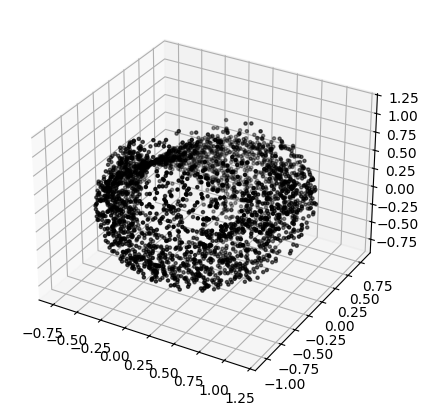

Lie PCA first eigenvalues: 4.2e-03  4.8e-03  5.4e-03  3.5e-02  Eigengap #3: 6.4e+00.


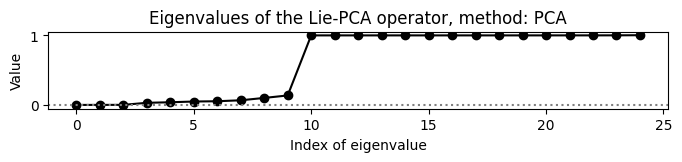

----> Optimization problem via bottom_lie_pca method for SO(3)  <----
Solve minimization problem... It 2/2. Duration 0:00:01. Remaining 0:00:00.
The optimal rep found is (5,) with cost 3.436e-02.
    ((5,), '+1') - cost 3.436e-02 (best cost #1/4)
    ((5,), '-1') - cost 3.436e-02 (best cost #2/4)
    ((1, 1, 3), '-1') - cost 2.895e+00 (best cost #3/4)
    ((1, 1, 3), '+1') - cost 2.895e+00 (best cost #4/4)
The representations (5,) and (5,) are equivalent.
Non-symmetric Hausdorff distance: 1.564e-01.


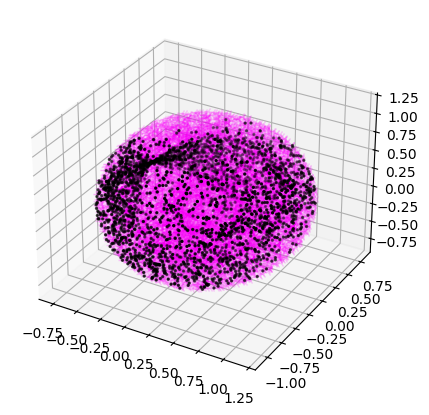

In [12]:
' Generate dataset '

# Parameters.
group = "SO(3)"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 3  # dimension of the group
ambient_dim = 5  # ambient dimension
nb_points = 3000  # number of sample points
frequency_max = 2  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=True,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
method = "bottom_lie_pca"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=None, span_ambient_space=False, method=method,
                                                    verbose=True, verbose_top_scores=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=30 ** 3, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

## IV.2. Representation of $\mathrm{SU}(2)$ in $\mathbb{R}^7$

Sampled 3000 random points on the orbit of SU(2) with rep (5,).


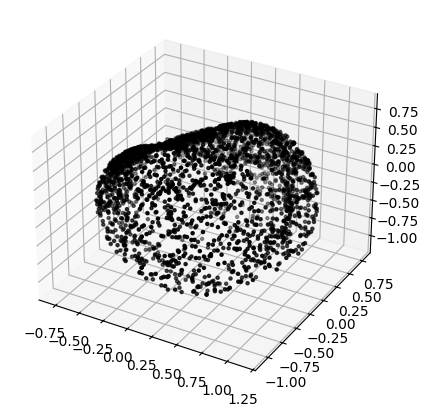

Lie PCA first eigenvalues: 4.8e-03  5.4e-03  6.5e-03  3.8e-02  Eigengap #3: 6.0e+00.


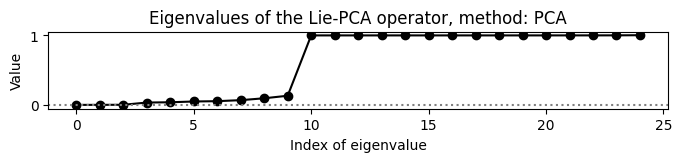

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 3/3. Duration 0:00:01. Remaining 0:00:00.
The optimal rep found is (5,) with cost 4.102e-02.
    ((5,), '+1') - cost 4.102e-02 (best cost #1/6)
    ((5,), '-1') - cost 4.102e-02 (best cost #2/6)
    ((1, 1, 3), '+1') - cost 2.874e+00 (best cost #3/6)
    ((1, 1, 3), '-1') - cost 2.874e+00 (best cost #4/6)
    ((1, 4), '+1') - cost 3.947e+00 (best cost #5/6)
    ((1, 4), '-1') - cost 3.947e+00 (best cost #6/6)
The representations (5,) and (5,) are equivalent.
Non-symmetric Hausdorff distance: 1.948e-01.


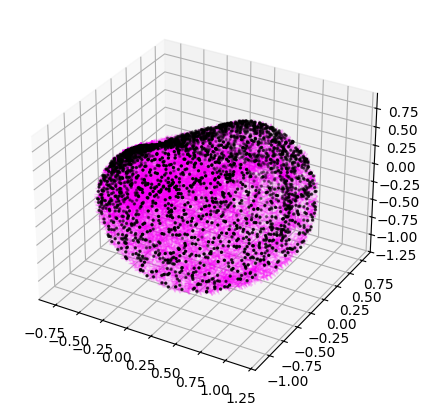

In [13]:
' Generate dataset '

# Parameters.
group = "SU(2)"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 3  # dimension of the group
ambient_dim = 5  # ambient dimension
nb_points = 3000  # number of sample points
frequency_max = 2  # maximal weight

# Generate dataset and plot.
pts, groundtruth_rep = sample_orbit_from_group(group=group, ambient_dim=ambient_dim, nb_points=nb_points,
                                               frequency_max=frequency_max, group_dim=group_dim, conjugate_algebra=True,
                                               translate_orbit=True, method="random", span_ambient_space=True,
                                               verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

' Project on Lie subalgebras '

# Parameters.
method = "bottom_lie_pca"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=None, span_ambient_space=False, method=method,
                                                    verbose=True, verbose_top_scores=True)

# Sanity check: orbit-equivalence of reps.
are_representations_equivalent(group=group, rep0=groundtruth_rep, rep1=optimal_rep, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=30 ** 3, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

# V. Additional experiments

## V.1. Comparison of two candidates: $\mathrm{SO}(3)$ and $T^3$ in $\mathbb{R}^6$

We sample on an orbit of the group $\mathrm{SO}(3)$ in $\mathbb{R}^6$. We suppose the group unknown.

Sampled 3000 random points on the orbit of SO(3) with rep (1, 5).


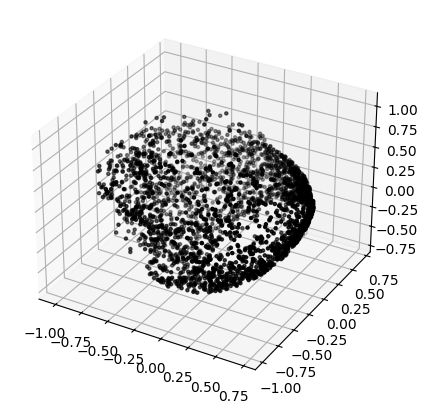

Lie PCA first eigenvalues: 3.5e-03  4.2e-03  5.1e-03  3.1e-02  Eigengap #3: 6.0e+00.


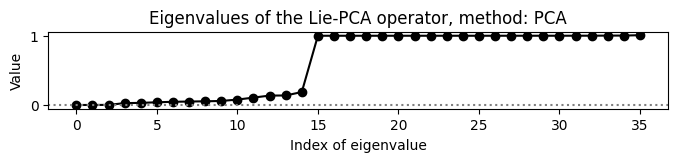

In [14]:
' Generate dataset '

# Parameters.
group = "SO(3)"  # group considered, among "torus", "SU(2)" and "SO(3)"
group_dim = 3  # dimension of the group
ambient_dim = 6  # ambient dimension
nb_points = 3000  # number of sample points
groundtruth_rep = (1, 5)

# Generate dataset and plot.
pts = sample_orbit_from_rep(group=group, rep_type=groundtruth_rep, nb_points=nb_points, method="random", verbose=True)
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 50  # number of neighbors for estimating tangent spaces
orbit_dim = 3  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

LiePCA suggest a symmetry group of dimension 3. We first test the torus.

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((0, 0, -1), (0, -1, 0), (-1, 0, 0)) with cost 1.963e-16.
Non-symmetric Hausdorff distance: 1.112e+00.


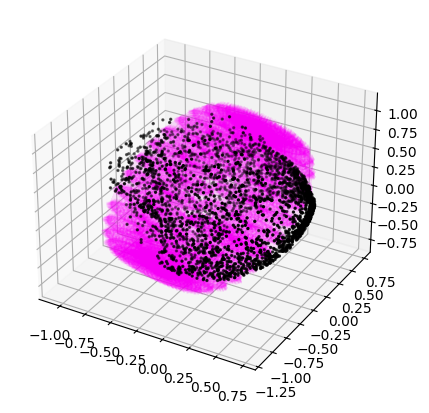

In [15]:
' Project on Lie subalgebras - T^3 '

group = "torus"

# Parameters.
frequency_max = 2  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=False,
                                                    method=method, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=30 ** 3, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

The algorithm seems to fail. However, with the group $\mathrm{SU}(2)$, a correct fit is observed.

----> Optimization problem via bottom_lie_pca method for SU(2)  <----
Solve minimization problem... It 4/4. Duration 0:00:01. Remaining 0:00:00.
The optimal rep found is (1, 5) with cost 3.876e-02.
Non-symmetric Hausdorff distance: 1.518e-01.


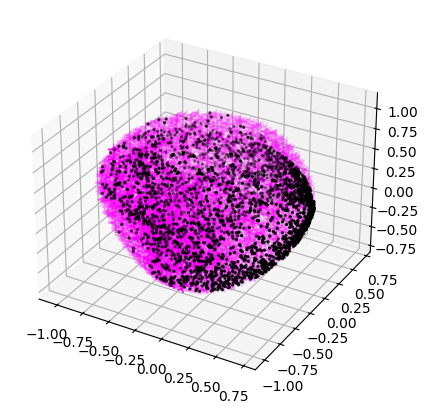

In [16]:
' Project on Lie subalgebras - SU(2) '

group = "SU(2)"

# Parameters.
method = "bottom_lie_pca"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=False,
                                                    method=method, verbose=True)

# Sanity check: Hausdorff distance.
orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra, x=pts[0],
                                  nb_points=30 ** 3, method="uniform", verbose=False, )
print_hausdorff_distance(pts, orbit)

# Plot orbit.
pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
pts_pca = pca.transform(pts)
orbit_pca = pca.transform(orbit)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=0.5, alpha=0.1, marker="3")
plt.show()

## V.2. Non-transitive action: Möbius strip in $\mathbb{R}^4$

In [17]:
import gudhi, scipy


def sample_on_mobius_strip(nb_points_init, nb_points_subsample, r=1):
    """Generate an approximately uniform set of points on a Möbius strip embedded in R^4, then down-sample the set
    by farthest-point subsampling. The parameter r controls the aspect ratio."""
    # Draw sample from uniform distribution.
    points = []
    angles = np.array([np.random.uniform(0, 2 * np.pi, nb_points_init) for _ in range(2)])
    for i in range(nb_points_init):
        theta, phi = angles[:, i]
        s = np.array(
            [np.cos(theta), np.sin(theta), r * np.cos(phi) * np.cos(theta / 2), r * np.cos(phi) * np.sin(theta / 2)])
        points.append(s)
    # Subsample with gudhi.
    points = np.array(gudhi.subsampling.choose_n_farthest_points(points=points, nb_points=nb_points_subsample))
    return points

/home/rtinarra/.cache/pypoetry/virtualenvs/liedetect-8nEXKn2J-py3.12/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:277: SyntaxWarning: invalid escape sequence '\l'
  """This function plots the persistence diagram from persistence values list, a np.array of shape (N x 2)


We sample 500 points on the Möbius strip, embedded in $\mathbb{R}^4$.

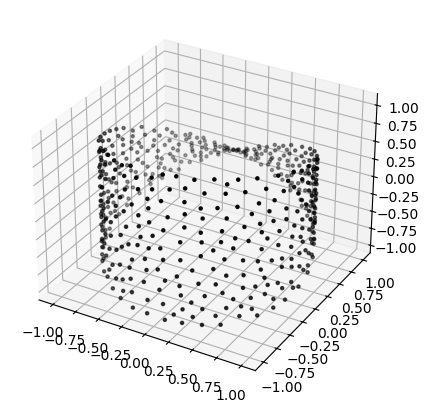

Lie PCA first eigenvalues: 4.2e-04  9.8e-02  9.9e-02  1.3e-01  Eigengap #2: 1.0e+00.


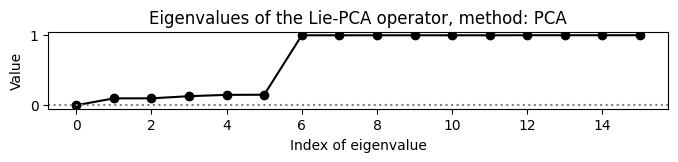

In [18]:
' Generate dataset '

# Generate sample.
pts = sample_on_mobius_strip(nb_points_init=10000, nb_points_subsample=500)

# Plot.
pca = sklearn.decomposition.PCA(n_components=3)
pts_pca = pca.fit_transform(pts)
_, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c='black', s=5)
plt.show()

' Lie-PCA '

# Parameters.
nb_neighbors = 15  # number of neighbors for estimating tangent spaces
orbit_dim = 2  # dimension for estimating tangent spaces
method = "PCA"  # method of estimation of tangent spaces

# Compute Lie PCA operator.
lie_pca = get_lie_pca_operator(pts=pts, nb_neighbors=nb_neighbors, orbit_dim=orbit_dim, method=method, correction=True,
                               verbose=True)

# Plot its eigenvalues.
vals = np.sort(np.linalg.eigvals(lie_pca).real)
_, ax = plt.subplots(figsize=(8, 1))
ax.plot(range(len(vals)), vals, c="black")
ax.scatter(range(len(vals)), vals, c="black")
ax.axhline(0, color="grey", linestyle="dotted")
ax.set_ylim((0 - 0.05, max(vals) + 0.05))
ax.set_title('Eigenvalues of the Lie-PCA operator, method: ' + method)
ax.set_xlabel("Index of eigenvalue")
ax.set_ylabel("Value")
plt.show()

LiePCA suggest a symmetry group of dimension 1, even though the manifold has dimension 2.
This was expected: the Möbius strip only supports an action of $\mathrm{SO}(2)$.
As seen in the following cell, this action is successfully retrieved: each point generates an orbit that stays within the point cloud. We show it by plotting several orbits, depending on different initial points.

----> Optimization problem via abelian method for torus  <----
The optimal rep found is ((1, 2),) with cost 1.372e-02.
Non-symmetric Hausdorff distance from sample to orbit: 8.123e-01.
Non-symmetric Hausdorff distance from orbit to sample: 1.180e-01.


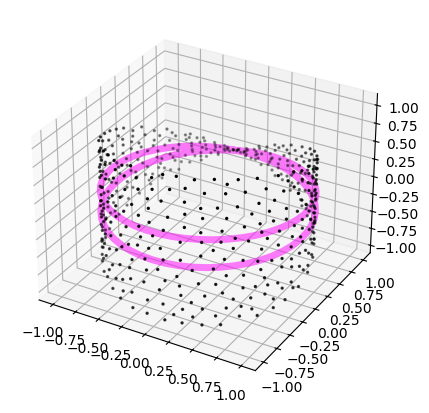

Non-symmetric Hausdorff distance from sample to orbit: 7.041e-01.
Non-symmetric Hausdorff distance from orbit to sample: 1.245e-01.


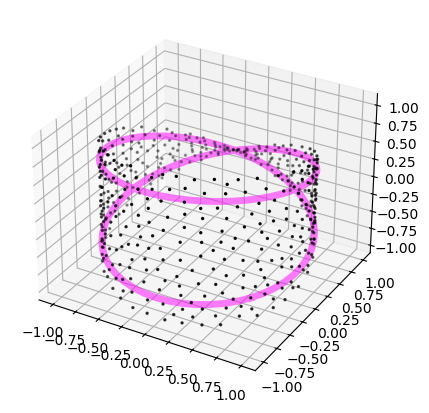

Non-symmetric Hausdorff distance from sample to orbit: 5.741e-01.
Non-symmetric Hausdorff distance from orbit to sample: 1.310e-01.


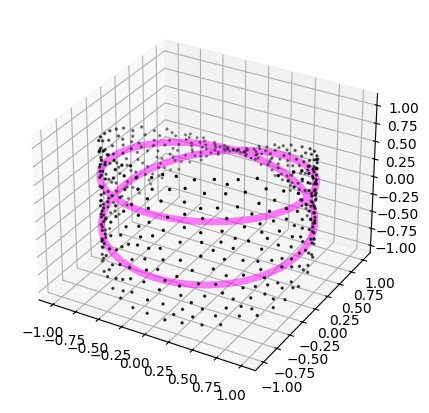

Non-symmetric Hausdorff distance from sample to orbit: 7.392e-01.
Non-symmetric Hausdorff distance from orbit to sample: 1.269e-01.


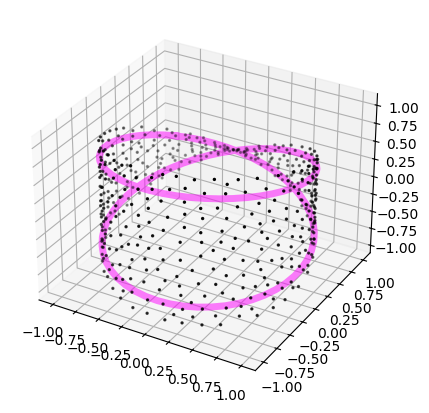

Non-symmetric Hausdorff distance from sample to orbit: 6.895e-01.
Non-symmetric Hausdorff distance from orbit to sample: 1.177e-01.


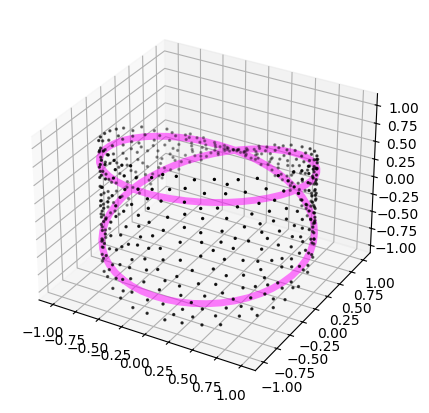

In [19]:
' Project on Lie subalgebras - SO(2) '

group = "torus"
group_dim = 1

# Parameters.
frequency_max = 3  # maximal weight to search
method = "abelian"  # optimization method

# Optimization.
optimal_rep, optimal_algebra = find_closest_algebra(group=group, lie_pca=lie_pca, group_dim=group_dim,
                                                    frequency_max=frequency_max, span_ambient_space=False,
                                                    method=method, verbose=True)

for idx_initial_point in range(0,500,100):
    # Sanity check: Hausdorff distance.
    orbit = sample_orbit_from_algebra(group=group, rep_type=optimal_rep, algebra=optimal_algebra,
                                      x=pts[idx_initial_point], nb_points=100, method="uniform", verbose=False, )
    hausdorff_dist_from_sample = scipy.spatial.distance.directed_hausdorff(pts, orbit)[0]
    hausdorff_dist_from_orbit = scipy.spatial.distance.directed_hausdorff(orbit, pts)[0]
    print(f"Non-symmetric \x1b[34mHausdorff distance from sample to orbit: {hausdorff_dist_from_sample:.3e}\x1b[0m.")
    print(f"Non-symmetric \x1b[34mHausdorff distance from orbit to sample: {hausdorff_dist_from_orbit:.3e}\x1b[0m.")

    # Plot orbit.
    pca = sklearn.decomposition.PCA(n_components=3).fit(pts)
    pts_pca = pca.transform(pts)
    orbit_pca = pca.transform(orbit)
    _, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": "3d"})
    ax.scatter(pts_pca[:, 0], pts_pca[:, 1], pts_pca[:, 2], c="black", s=2)
    ax.plot(orbit_pca[:, 0], orbit_pca[:, 1], orbit_pca[:, 2], c='magenta', lw=5, alpha=0.5)
    plt.show()